In [41]:
#!/usr/bin/env python3
"""
Test Trained PPO Model for Combustion Integrator Switching
Loads a trained model and tests it under specified conditions with comparison plots
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
import cantera as ct
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Import the environment and PPO classes
from environment import IntegratorSwitchingEnv
from ppo_training import PPONetwork,LagrangeReward1


In [42]:
# Helper functions for analysis and plotting
def calculate_action_distribution(actions, solver_names):
    """Calculate action distribution from action list"""
    if not actions:
        return {}
    
    action_counts = {}
    for action in actions:
        action_counts[action] = action_counts.get(action, 0) + 1
    
    total_actions = len(actions)
    distribution = {}
    for action, count in action_counts.items():
        solver_name = solver_names[action] if action < len(solver_names) else f"Action_{action}"
        distribution[solver_name] = count / total_actions
    
    return distribution

class ModelSimulator:
    """Simple class to run PPO model simulations"""
    
    def __init__(self, model_path, mechanism_file, fuel='nc12h26', oxidizer='O2:0.21, N2:0.79', hidden_dims=[128, 64]):
        self.model_path = model_path
        self.mechanism_file = mechanism_file
        self.fuel = fuel
        self.oxidizer = oxidizer
        
        # Load the trained model
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_data = torch.load(model_path, map_location=self.device)
        
        # Setup environment and model
        self._setup_environment()
        self._load_model(hidden_dims)
        
        print(f"Model loaded from: {model_path}")
        print(f"Trained for {self.model_data['episode']} episodes")
        print(f"Using device: {self.device}")
    
    def _setup_environment(self):
        """Setup environment with same configuration as training"""
        # Reward function configuration (same as training)
        reward_config = {
            'epsilon': 1e-3,
            'lambda_init': 1.0,
            'lambda_lr': 0.05,
            'target_violation': 0.0,
            'cpu_log_delta': 1e-3,
            'reward_clip': 5.0
        }
        reward_function = LagrangeReward1(**reward_config)
        
        # Solver configurations (same as training)
        solver_configs = [
            {'type': 'cvode', 'rtol': 1e-6, 'atol': 1e-12, 'mxsteps': 100000, 'name': 'CVODE_BDF'},
            {'type': 'qss', 'dtmin': 1e-16, 'dtmax': 1e-6, 'stabilityCheck': False, 
             'itermax': 1, 'epsmin': 0.02, 'epsmax': 10.0, 'abstol': 1e-8, 'mxsteps': 1000, 'name': 'QSS'},
        ]
        
        # Create environment
        self.env = IntegratorSwitchingEnv(
            mechanism_file=self.mechanism_file,
            fuel=self.fuel,
            oxidizer=self.oxidizer,
            temp_range=(300, 1100),
            phi_range=(0.5, 2.0),
            pressure_range=(1, 6),
            time_range=(1e-3, 2e-2),
            dt_range=(1e-6, 1e-6),
            etol=1e-3,
            super_steps=100,
            reward_function=reward_function,
            solver_configs=solver_configs,
            verbose=False
        )
        
        self.obs_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.solver_names = self.env.get_solver_names()
        
        print(f"Environment created with {len(self.solver_names)} solvers: {self.solver_names}")
    
    def _load_model(self, hidden_dims):
        """Load the trained PPO network"""
        self.network = PPONetwork(self.obs_dim, self.action_dim, hidden_dims=hidden_dims).to(self.device)
        self.network.load_state_dict(self.model_data['model_state_dict'])
        self.network.eval()
        
        print(f"Network loaded: {sum(p.numel() for p in self.network.parameters()):,} parameters")
    
    def get_action(self, obs, deterministic=True):
        """Get action from trained model"""
        with torch.no_grad():
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
            logits, value = self.network(obs_tensor)
            
            if deterministic:
                action = torch.argmax(logits, dim=1).item()
            else:
                probs = Categorical(logits=logits)
                action = probs.sample().item()
            
            log_prob = F.log_softmax(logits, dim=1)[0, action].item()
            return action, log_prob, value.item()
    
    def run_simulation(self, conditions, use_rl=True, fixed_action=None, save_trajectory=True, verbose=True):
        """
        Run simulation with specified conditions
        
        Args:
            conditions: Dict with 'temperature', 'pressure', 'phi', 'total_time'
            use_rl: If True, use RL agent; if False, use fixed action
            fixed_action: Action to use if use_rl=False (0 or 1)
            save_trajectory: If True, save full trajectory data
            verbose: If True, show progress bar and print info
        
        Returns:
            Dict with simulation results and trajectory data
        """
        if verbose:
            print(f"\nRunning simulation:")
            print(f"  T={conditions['temperature']:.0f}K, P={conditions['pressure']:.1f}bar, φ={conditions['phi']:.2f}")
            print(f"  Total time: {conditions['total_time']:.2e}s")
            print(f"  Mode: {'RL Agent' if use_rl else f'Fixed Action {fixed_action} ({self.solver_names[fixed_action]})'}")
        
        # Reset environment
        obs, info = self.env.reset(
            temperature=conditions['temperature'],
            pressure=conditions['pressure'] * ct.one_atm,
            phi=conditions['phi'],
            total_time=conditions['total_time']
        )
    
        # Get reference data
        ref_temps = self.env.ref_states[:, 0]
        ref_times = self.env.ref_times
        ref_species = self.env.ref_states[:, 1:]  # All species except temperature
        print(f"Max reference temperature: {np.max(ref_temps)}")
        total_reward = 0
        total_cpu_time = 0
        step_count = 0
        
        # Progress bar
        if verbose:
            pbar = tqdm(total=self.env.n_episodes, desc="Simulation Progress")
        
        while True:
            # Get action
            if use_rl:
                action, log_prob, value = self.get_action(obs, deterministic=True)
            else:
                action = fixed_action
            
            # Step environment
            next_obs, reward, terminated, truncated, next_info = self.env.step(action)
            done = terminated or truncated
            
            total_reward += reward
            total_cpu_time += next_info.get('cpu_time', 0)
            step_count += 1
            
            # Update progress
            if verbose:
                temp = self.env.current_state[0]
                cpu_time = next_info.get('cpu_time', 0)
                pbar.set_postfix({
                    'T': f'{temp:.1f}K',
                    'A': action,
                    'R': f'{reward:.1f}',
                    'C': f'{cpu_time:.3f}s'
                })
                pbar.update(1)
            
            if done:
                break
            
            obs = next_obs
        
        if verbose:
            pbar.close()
        
        trajectory_data = {
            'reference_states': ref_species,
            'reference_times': ref_times,
            'reference_temperatures': ref_temps,
            'states': self.env.states_trajectory,
            'times': self.env.times_trajectory,
            'actions': self.env.action_history,
            'rewards': self.env.episode_rewards,
            'timestep_errors': self.env.timestep_errors,
            'cpu_times': self.env.cpu_times,
            
        }
        
        
        # Calculate final results
        results = {
            'conditions': conditions.copy(),
            'total_reward': total_reward,
            'total_cpu_time': total_cpu_time,
            'episode_length': step_count,
            'mean_reward_per_step': total_reward / step_count if step_count > 0 else 0,
            'mean_cpu_time_per_step': total_cpu_time / step_count if step_count > 0 else 0,
            'ignition_detected': info.get('steady_state_info', {}).get('ignition_detected', False),
            'ignition_time': info.get('steady_state_info', {}).get('ignition_time', None),
            'reached_steady_state': info.get('steady_state_info', {}).get('reached_steady_state', False),
            'final_temperature': self.env.current_state[0],
            'max_temperature': np.max(np.array(self.env.states_trajectory)[:,0]),
            'max_reference_temperature': np.max(ref_temps),
            'final_reference_temperature': ref_temps[-1],
            'action_distribution': calculate_action_distribution(trajectory_data['actions'] if trajectory_data else [], self.solver_names),
            'trajectory_data': trajectory_data,
            'reference_states': ref_species,
            'reference_times': ref_times
        }
        
        return results


In [43]:
def compare_methods(simulator, conditions, save_plots=True, output_dir="test_results"):
    """
    Compare RL agent vs fixed actions (0 and 1)
    
    Args:
        simulator: ModelSimulator instance
        conditions: Simulation conditions
        save_plots: Whether to save plots
        output_dir: Directory to save results
    
    Returns:
        Dict with comparison results
    """
    print(f"\n{'='*80}")
    print("COMPARING RL AGENT vs FIXED ACTIONS")
    print(f"{'='*80}")
    
    # Create output directory
    if save_plots:
        os.makedirs(output_dir, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        condition_str = f"T{conditions['temperature']:.0f}_P{conditions['pressure']:.1f}_phi{conditions['phi']:.2f}"
        plot_dir = os.path.join(output_dir, f"comparison_{condition_str}_{timestamp}")
        os.makedirs(plot_dir, exist_ok=True)
    
    # Run simulations
    results = {}
    
    # RL Agent
    print("\n1. Running RL Agent...")
    results['rl'] = simulator.run_simulation(conditions, use_rl=True, save_trajectory=True)
    
    # # Fixed Action 0 (CVODE_BDF)
    # print("\n2. Running Fixed Action 0 (CVODE_BDF)...")
    # results['fixed_0'] = simulator.run_simulation(conditions, use_rl=False, fixed_action=0, save_trajectory=True)
    
    # Fixed Action 1 (QSS)
    print("\n3. Running Fixed Action 1 (QSS)...")
    results['fixed_1'] = simulator.run_simulation(conditions, use_rl=False, fixed_action=1, save_trajectory=True)
    
    # Print comparison summary
    print_comparison_summary(results)
    
    # Create comparison plots
    if save_plots:
        create_comparison_plots(results, plot_dir, simulator.solver_names)
        print(f"\nPlots saved to: {plot_dir}")
    
    return results


def print_comparison_summary(results):
    """Print comparison summary"""
    print(f"\n{'='*80}")
    print("COMPARISON SUMMARY")
    print(f"{'='*80}")
    
    methods = ['RL Agent', 'Fixed Action 0 (CVODE_BDF)', 'Fixed Action 1 (QSS)']
    result_keys = ['rl', 'fixed_0', 'fixed_1']
    
    print(f"{'Method':<25} {'Reward':<10} {'CPU Time':<10} {'Length':<8} {'Max T':<8} {'Ignition':<8}")
    print("-" * 80)
    
    for method, key in zip(methods, result_keys):
        r = results[key]
        ignition = "Yes" if r['ignition_detected'] else "No"
        print(f"{method:<25} {r['total_reward']:<10.2f} {r['total_cpu_time']:<10.3f} "
              f"{r['episode_length']:<8} {r['max_temperature']:<8.0f} {ignition:<8}")
    
    print(f"\nAction Distributions:")
    for method, key in zip(methods, result_keys):
        r = results[key]
        print(f"  {method}: {r['action_distribution']}")


def create_comparison_plots(results, plot_dir, solver_names):
    """Create comprehensive comparison plots"""
    # Create main comparison figure
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle(f'RL Agent vs Fixed Actions Comparison\n'
                f'T={results["rl"]["conditions"]["temperature"]:.0f}K, '
                f'P={results["rl"]["conditions"]["pressure"]:.1f}bar, '
                f'φ={results["rl"]["conditions"]["phi"]:.2f}', fontsize=14)
    
    colors = {'rl': 'blue', 'fixed_0': 'red', 'fixed_1': 'green'}
    labels = {'rl': 'RL Agent', 'fixed_0': 'Fixed CVODE_BDF', 'fixed_1': 'Fixed QSS'}
    
    # Plot 1: Temperature profiles
    ax1 = axes[0, 0]
    for key, color in colors.items():
        r = results[key]
        if r['trajectory_data']:
            times = r['trajectory_data']['times']
            temps = r['trajectory_data']['temperatures']
            ax1.plot(times, temps, color=color, linewidth=2, label=labels[key])
    
    # Add reference
    if results['rl']['trajectory_data']:
        ref_times = results['rl']['trajectory_data']['reference_times']
        ref_temps = results['rl']['trajectory_data']['reference_temperatures']
        ax1.plot(ref_times, ref_temps, 'k--', linewidth=2, label='Reference', alpha=0.7)
    
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Temperature (K)')
    ax1.set_title('Temperature Profiles')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: CPU time profiles
    ax2 = axes[0, 1]
    for key, color in colors.items():
        r = results[key]
        if r['trajectory_data']:
            times = r['trajectory_data']['times']
            cpu_times = r['trajectory_data']['cpu_times']
            ax2.plot(times, cpu_times, color=color, linewidth=2, label=labels[key])
    
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('CPU Time (s)')
    ax2.set_title('CPU Time Profiles')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Action trajectories
    ax3 = axes[1, 0]
    for key, color in colors.items():
        r = results[key]
        if r['trajectory_data']:
            times = r['trajectory_data']['times']
            actions = r['trajectory_data']['actions']
            ax3.scatter(times, actions, color=color, s=10, alpha=0.7, label=labels[key])
    
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Action')
    ax3.set_title('Action Trajectories')
    ax3.set_yticks([0, 1])
    ax3.set_yticklabels(solver_names)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Reward profiles
    ax4 = axes[1, 1]
    for key, color in colors.items():
        r = results[key]
        if r['trajectory_data']:
            times = r['trajectory_data']['times']
            rewards = r['trajectory_data']['rewards']
            ax4.plot(times, rewards, color=color, linewidth=2, label=labels[key])
    
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Reward')
    ax4.set_title('Reward Profiles')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Error profiles
    ax5 = axes[2, 0]
    for key, color in colors.items():
        r = results[key]
        if r['trajectory_data']:
            times = r['trajectory_data']['times']
            errors = r['trajectory_data']['timestep_errors']
            ax5.semilogy(times, errors, color=color, linewidth=2, label=labels[key])
    
    ax5.set_xlabel('Time (s)')
    ax5.set_ylabel('Timestep Error (log scale)')
    ax5.set_title('Error Profiles')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Performance metrics bar chart
    ax6 = axes[2, 1]
    metrics = ['Total Reward', 'Total CPU Time', 'Episode Length']
    x = np.arange(len(metrics))
    width = 0.25
    
    rl_vals = [results['rl']['total_reward'], results['rl']['total_cpu_time'], results['rl']['episode_length']]
    fixed0_vals = [results['fixed_0']['total_reward'], results['fixed_0']['total_cpu_time'], results['fixed_0']['episode_length']]
    fixed1_vals = [results['fixed_1']['total_reward'], results['fixed_1']['total_cpu_time'], results['fixed_1']['episode_length']]
    
    ax6.bar(x - width, rl_vals, width, label='RL Agent', color='blue', alpha=0.7)
    ax6.bar(x, fixed0_vals, width, label='Fixed CVODE_BDF', color='red', alpha=0.7)
    ax6.bar(x + width, fixed1_vals, width, label='Fixed QSS', color='green', alpha=0.7)
    
    ax6.set_xlabel('Metrics')
    ax6.set_ylabel('Value')
    ax6.set_title('Performance Comparison')
    ax6.set_xticks(x)
    ax6.set_xticklabels(metrics, rotation=45)
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'comparison_overview.png'), dpi=150, bbox_inches='tight')
    plt.close()
    
    # Create additional plots
    create_species_plots(results, plot_dir)
    create_rl_analysis_plots(results['rl'], plot_dir, solver_names)


def create_species_plots(results, plot_dir):
    """Create species concentration comparison plots"""
    # Select key species for plotting
    key_species = ['H2O', 'CO2', 'O2', 'H2', 'OH', 'H', 'O']
    
    # Find available species in the data
    if results['rl']['trajectory_data']:
        available_species = results['rl']['trajectory_data']['species_names']
        plot_species = [s for s in key_species if s in available_species]
        
        if not plot_species:
            plot_species = available_species[:6]  # Take first 6 if key species not found
        
        n_species = len(plot_species)
        n_cols = 3
        n_rows = (n_species + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        fig.suptitle('Species Concentration Comparison', fontsize=16)
        
        colors = {'rl': 'blue', 'fixed_0': 'red', 'fixed_1': 'green'}
        labels = {'rl': 'RL Agent', 'fixed_0': 'Fixed CVODE_BDF', 'fixed_1': 'Fixed QSS'}
        
        for i, species in enumerate(plot_species):
            row = i // n_cols
            col = i % n_cols
            ax = axes[row, col]
            
            for key, color in colors.items():
                r = results[key]
                if r['trajectory_data'] and species in r['trajectory_data']['species_trajectories']:
                    times = r['trajectory_data']['times']
                    concentrations = r['trajectory_data']['species_trajectories'][species]
                    ax.plot(times, concentrations, color=color, linewidth=2, label=labels[key])
            
            # Add reference
            if results['rl']['trajectory_data'] and species in results['rl']['trajectory_data']['species_trajectories']:
                ref_times = results['rl']['trajectory_data']['reference_times']
                ref_concentrations = results['rl']['trajectory_data']['species_trajectories'][species]
                ax.plot(ref_times, ref_concentrations, 'k--', linewidth=2, label='Reference', alpha=0.7)
            
            ax.set_xlabel('Time (s)')
            ax.set_ylabel(f'{species} Mass Fraction')
            ax.set_title(f'{species} Concentration')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_yscale('log')
        
        # Hide unused subplots
        for i in range(n_species, n_rows * n_cols):
            row = i // n_cols
            col = i % n_cols
            axes[row, col].set_visible(False)
        
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, 'species_comparison.png'), dpi=150, bbox_inches='tight')
        plt.close()


def create_rl_analysis_plots(rl_results, plot_dir, solver_names):
    """Create detailed RL agent analysis plots"""
    if not rl_results['trajectory_data']:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('RL Agent Detailed Analysis', fontsize=14)
    
    times = rl_results['trajectory_data']['times']
    temps = rl_results['trajectory_data']['temperatures']
    ref_temps = rl_results['trajectory_data']['reference_temperatures']
    actions = rl_results['trajectory_data']['actions']
    rewards = rl_results['trajectory_data']['rewards']
    cpu_times = rl_results['trajectory_data']['cpu_times']
    errors = rl_results['trajectory_data']['timestep_errors']
    
    # Plot 1: Temperature vs Reference with error
    ax1 = axes[0, 0]
    ax1.plot(times, temps, 'b-', linewidth=2, label='RL Agent')
    ax1.plot(times, ref_temps, 'r--', linewidth=2, label='Reference')
    
    # Calculate and plot temperature error
    temp_errors = np.abs(np.array(temps) - np.array(ref_temps))
    ax1_twin = ax1.twinx()
    ax1_twin.semilogy(times, temp_errors, 'g:', linewidth=1, alpha=0.7, label='Temperature Error')
    ax1_twin.set_ylabel('Temperature Error (K)', color='g')
    
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Temperature (K)')
    ax1.set_title('Temperature Comparison with Error')
    ax1.legend(loc='upper left')
    ax1_twin.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Action selection over time
    ax2 = axes[0, 1]
    action_colors = ['red', 'blue']
    for i, action in enumerate(actions):
        color = action_colors[action % len(action_colors)]
        ax2.scatter(times[i], action, c=color, s=20, alpha=0.7)
    
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Action')
    ax2.set_title('Action Selection Over Time')
    ax2.set_yticks([0, 1])
    ax2.set_yticklabels(solver_names)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Reward and CPU time correlation
    ax3 = axes[1, 0]
    scatter = ax3.scatter(cpu_times, rewards, c=times, cmap='viridis', s=30, alpha=0.7)
    ax3.set_xlabel('CPU Time (s)')
    ax3.set_ylabel('Reward')
    ax3.set_title('Reward vs CPU Time')
    plt.colorbar(scatter, ax=ax3, label='Time (s)')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Error analysis
    ax4 = axes[1, 1]
    ax4.semilogy(times, errors, 'r-', linewidth=2, label='Timestep Error')
    ax4.axhline(y=1e-3, color='k', linestyle='--', alpha=0.7, label='Error Threshold')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Timestep Error (log scale)')
    ax4.set_title('Error Analysis')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, 'rl_analysis.png'), dpi=150, bbox_inches='tight')
    plt.close()



In [46]:
models_256_128_64 = [
    'logs/ppo_integrator_switching_20250918_095720/models/model_ep_300.pt',
    # 'logs/ppo_integrator_switching_20250914_090755/models/model_ep_3000.pt',
    # 'logs/ppo_integrator_switching_20250914_090755/models/model_ep_1500.pt',
    
]

models_128_64 = [
    # 'logs/ppo_integrator_switching_20250913_201233/models/model_ep_4500.pt',
    # 'logs/ppo_integrator_switching_20250913_201233/models/model_ep_4000.pt',
    # 'logs/ppo_integrator_switching_20250913_201233/models/model_ep_2000.pt' 
]

In [47]:
# Path to your trained model

# Mechanism file
mechanism_file = "../large_mechanism/n-dodecane.yaml"
hidden_dims = [256, 128, 64]
model_index = 0
if hidden_dims == [256, 128, 64]:
    model_path = models_256_128_64[model_index]
elif hidden_dims == [128, 64]:
    model_path = models_128_64[model_index]

simulator = ModelSimulator(model_path, mechanism_file, hidden_dims=hidden_dims)

Environment created with 2 solvers: ['CVODE_BDF', 'QSS']
Network loaded: 44,163 parameters
Model loaded from: logs/ppo_integrator_switching_20250918_095720/models/model_ep_300.pt
Trained for 300 episodes
Using device: cpu


/var/folders/0c/k7ymw65d2fbf_9503y8nvm680000gn/T/ipykernel_33468/1834450300.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_data = torch.load(model_path, map

In [48]:
# Test conditions
conditions = {
    'temperature': 1000,    # K
    'pressure': 1.0,       # bar
    'phi': 1,            # equivalence ratio
    'total_time': 1e-1     # s
}



In [49]:
results = simulator.run_simulation(conditions)


Running simulation:
  T=1000K, P=1.0bar, φ=1.00
  Total time: 1.00e-01s
  Mode: RL Agent
Max reference temperature: 2588.96128927475


Simulation Progress: 100%|██████████| 100/100 [01:24<00:00,  1.19it/s, T=2631.6K, A=0, R=-2.0, C=1.616s]


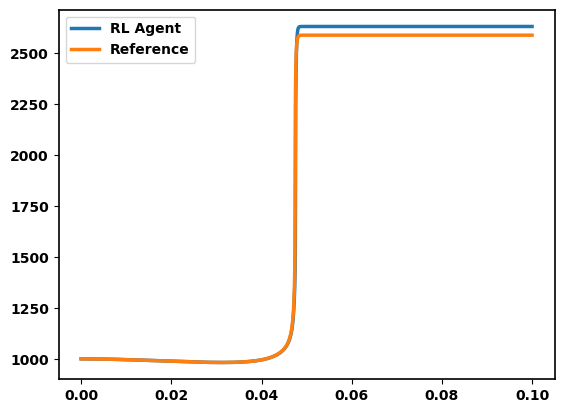

In [50]:
fig, ax = plt.subplots()
ax.plot(results['trajectory_data']['times'], np.array(results['trajectory_data']['states'])[:,0], label='RL Agent')
ax.plot(results['trajectory_data']['reference_times'], results['trajectory_data']['reference_temperatures'], label='Reference')
ax.legend()
plt.show()

In [39]:
results_comparison = compare_methods(simulator, conditions, save_plots=False, output_dir="test_results")


COMPARING RL AGENT vs FIXED ACTIONS

1. Running RL Agent...

Running simulation:
  T=1000K, P=1.0bar, φ=1.00
  Total time: 1.00e-01s
  Mode: RL Agent
Max reference temperature: 2588.96128927475


Simulation Progress: 100%|██████████| 100/100 [01:23<00:00,  1.20it/s, T=2631.6K, A=0, R=-2.0, C=1.528s]



2. Running Fixed Action 0 (CVODE_BDF)...

Running simulation:
  T=1000K, P=1.0bar, φ=1.00
  Total time: 1.00e-01s
  Mode: Fixed Action 0 (CVODE_BDF)
Max reference temperature: 2588.96128927475


Simulation Progress: 100%|██████████| 100/100 [03:47<00:00,  2.28s/it, T=2589.0K, A=0, R=0.0, C=2.182s]



3. Running Fixed Action 1 (QSS)...

Running simulation:
  T=1000K, P=1.0bar, φ=1.00
  Total time: 1.00e-01s
  Mode: Fixed Action 1 (QSS)
Max reference temperature: 2588.96128927475


Simulation Progress: 100%|██████████| 100/100 [00:07<00:00, 14.05it/s, T=2635.1K, A=1, R=-2.0, C=0.071s]


COMPARISON SUMMARY
Method                    Reward     CPU Time   Length   Max T    Ignition
--------------------------------------------------------------------------------
RL Agent                  3.98       82.974     100      2632     No      
Fixed Action 0 (CVODE_BDF) -49.65     227.481    100      2589     No      
Fixed Action 1 (QSS)      2.32       7.059      100      2635     No      

Action Distributions:
  RL Agent: {'QSS': 0.48, 'CVODE_BDF': 0.52}
  Fixed Action 0 (CVODE_BDF): {'CVODE_BDF': 1.0}
  Fixed Action 1 (QSS): {'QSS': 1.0}


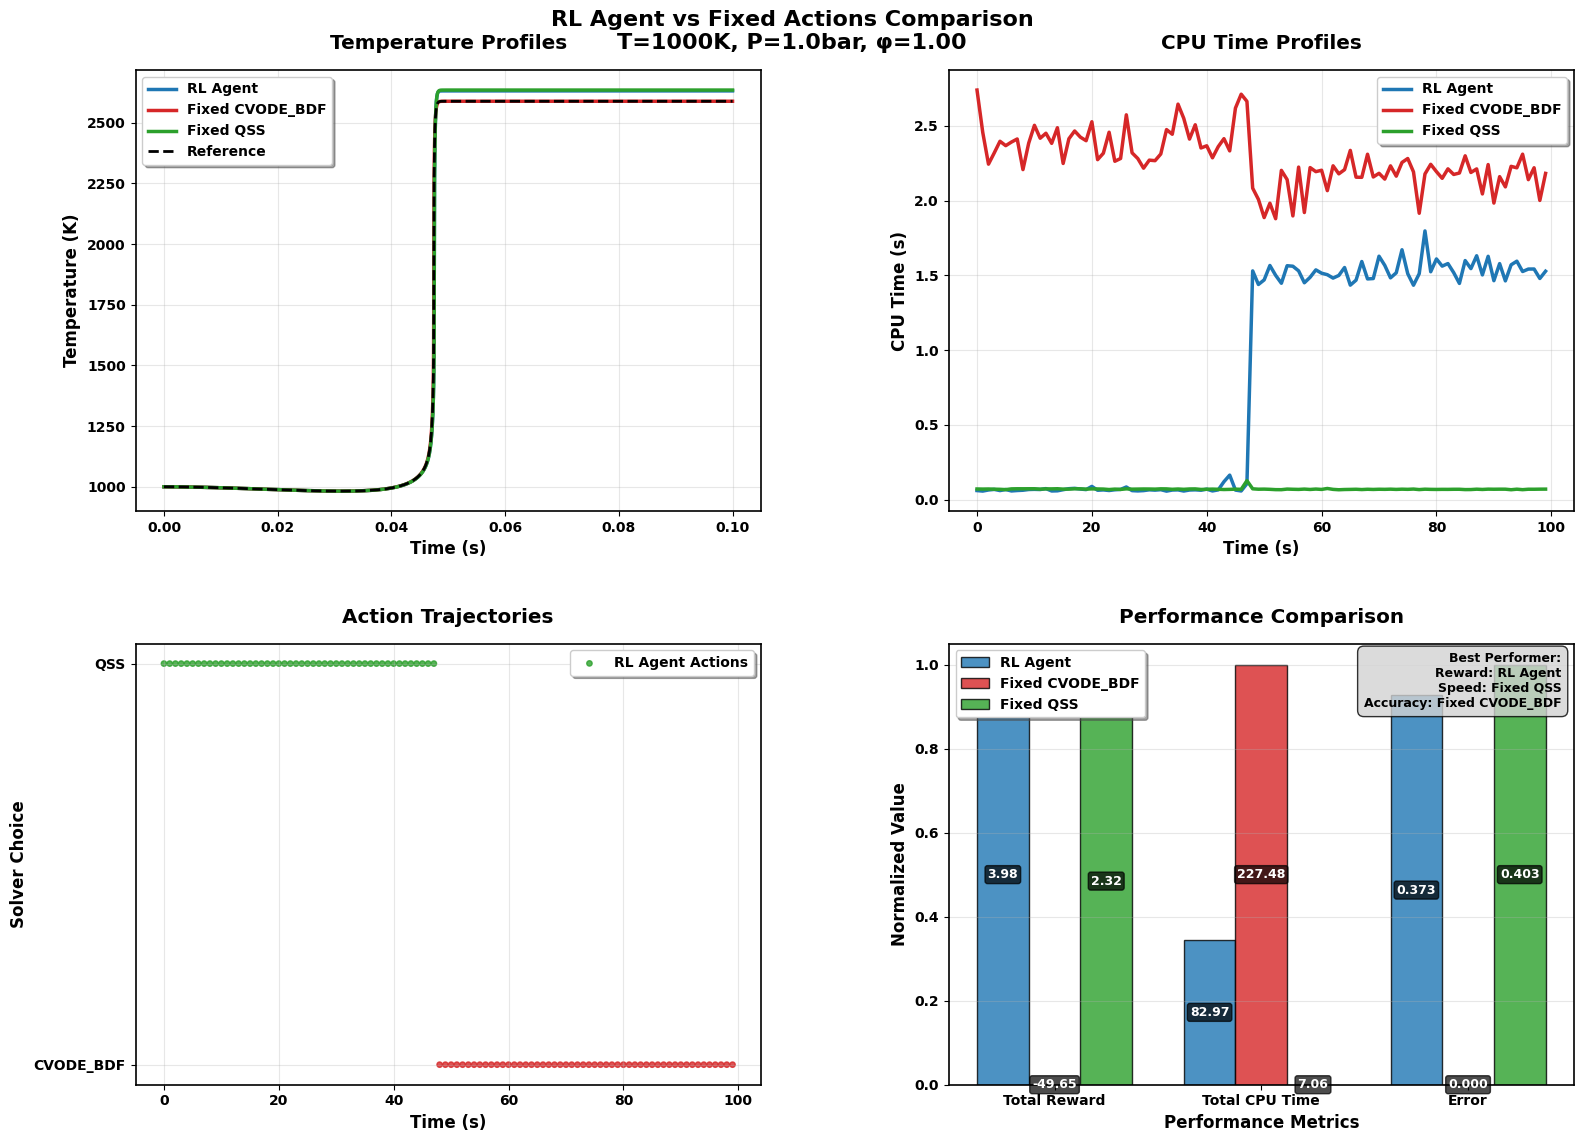

In [40]:
import matplotlib.pyplot as plt
import numpy as np

results = results_comparison
# Set publication-ready style
plt.rcParams.update({
    'font.size': 12,
    'font.weight': 'bold',
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.titlesize': 14,
    'figure.titleweight': 'bold',
    'axes.linewidth': 1.2,
    'grid.linewidth': 0.8,
    'lines.linewidth': 2.5
})

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
temp = results["rl"]["conditions"]["temperature"]
P=results["rl"]["conditions"]["pressure"]
φ=results["rl"]["conditions"]["phi"]
fig.suptitle(f'RL Agent vs Fixed Actions Comparison\n'
             f'T={temp:.0f}K, '
             f'P={P:.1f}bar, '
             f'φ={φ:.2f}', 
             fontsize=16, fontweight='bold', y=0.95)

colors = {'rl': '#1f77b4', 'fixed_0': '#d62728', 'fixed_1': '#2ca02c'}
labels = {'rl': 'RL Agent', 'fixed_0': 'Fixed CVODE_BDF', 'fixed_1': 'Fixed QSS'}
solver_names = simulator.solver_names

# Plot 1: Temperature profiles
ax1 = axes[0, 0]
for key, color in colors.items():
    r = results[key]
    if r['trajectory_data']:
        times = r['trajectory_data']['times']
        temps = np.array(r['trajectory_data']['states'])[:,0]
        ax1.plot(times, temps, color=color, linewidth=2.5, label=labels[key])

# Add reference line
ax1.plot(results['rl']['trajectory_data']['reference_times'], 
         np.array(results['rl']['trajectory_data']['reference_temperatures']), 
         label='Reference', linestyle='--', color='black', linewidth=2)

ax1.set_xlabel('Time (s)', fontweight='bold')
ax1.set_ylabel('Temperature (K)', fontweight='bold')
ax1.set_title('Temperature Profiles', fontweight='bold', pad=15)
ax1.legend(frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.3, linewidth=0.8)

# Plot 2: CPU time profiles
ax2 = axes[0, 1]
for key, color in colors.items():
    r = results[key]
    if r['trajectory_data']:
        cpu_times = r['trajectory_data']['cpu_times']
        times = np.arange(len(cpu_times))
        ax2.plot(times, cpu_times, color=color, linewidth=2.5, label=labels[key])

ax2.set_xlabel('Time (s)', fontweight='bold')
ax2.set_ylabel('CPU Time (s)', fontweight='bold')
ax2.set_title('CPU Time Profiles', fontweight='bold', pad=15)
ax2.legend(frameon=True, fancybox=True, shadow=True)
ax2.grid(True, alpha=0.3, linewidth=0.8)

# Plot 3: Action trajectories
ax3 = axes[1, 0]
r = results['rl']
if r['trajectory_data']:
    actions = r['trajectory_data']['actions']
    times = np.arange(len(actions))
    # Use different colors for different actions
    action_colors = ['#d62728' if a == 0 else '#2ca02c' for a in actions]
    ax3.scatter(times, actions, c=action_colors, s=15, alpha=0.8, label='RL Agent Actions')

ax3.set_xlabel('Time (s)', fontweight='bold')
ax3.set_ylabel('Solver Choice', fontweight='bold')
ax3.set_title('Action Trajectories', fontweight='bold', pad=15)
ax3.set_yticks([0, 1])
ax3.set_yticklabels(solver_names, fontweight='bold')
ax3.legend(frameon=True, fancybox=True, shadow=True)
ax3.grid(True, alpha=0.3, linewidth=0.8)

# Plot 4: Improved Performance metrics bar chart
ax4 = axes[1, 1]

# Get raw values
rl_vals = [results['rl']['total_reward'], 
           results['rl']['total_cpu_time'], 
           np.sum(results['rl']['trajectory_data']['timestep_errors'])]
fixed0_vals = [results['fixed_0']['total_reward'], 
               results['fixed_0']['total_cpu_time'], 
               np.sum(results['fixed_0']['trajectory_data']['timestep_errors'])]
fixed1_vals = [results['fixed_1']['total_reward'], 
               results['fixed_1']['total_cpu_time'], 
               np.sum(results['fixed_1']['trajectory_data']['timestep_errors'])]

# Create the data structure for plotting
data = {
    'RL Agent': rl_vals,
    'Fixed CVODE_BDF': fixed0_vals,
    'Fixed QSS': fixed1_vals
}

metrics = ['Total Reward', 'Total CPU Time', 'Error']
x = np.arange(len(metrics))
width = 0.25

# Normalize values for visualization (0-1 scale for each metric)
all_vals = np.array([rl_vals, fixed0_vals, fixed1_vals])
max_vals = np.max(all_vals, axis=0)
min_vals = np.min(all_vals, axis=0)

# Handle division by zero
ranges = max_vals - min_vals
ranges[ranges == 0] = 1  # Avoid division by zero

normalized_data = {}
raw_data = {}
for i, (method, vals) in enumerate(data.items()):
    normalized_data[method] = (np.array(vals) - min_vals) / ranges
    raw_data[method] = vals

# Create bars
bar_colors = ['#1f77b4', '#d62728', '#2ca02c']
bar_alpha = 0.8

bars = []
for i, (method, norm_vals) in enumerate(normalized_data.items()):
    bar = ax4.bar(x + i*width - width, norm_vals, width, 
                  label=method, color=bar_colors[i], alpha=bar_alpha, 
                  edgecolor='black', linewidth=1)
    bars.append(bar)
    
    # Add value labels inside bars
    for j, (bar_rect, raw_val) in enumerate(zip(bar, raw_data[method])):
        height = bar_rect.get_height()
        # Position text in the middle of the bar
        y_pos = height / 2
        
        # Format the value based on its magnitude
        if abs(raw_val) >= 1000:
            text = f'{raw_val:.1e}'
        elif abs(raw_val) >= 1:
            text = f'{raw_val:.2f}'
        else:
            text = f'{raw_val:.3f}'
            
        ax4.text(bar_rect.get_x() + bar_rect.get_width()/2., y_pos,
                text, ha='center', va='center', 
                fontweight='bold', fontsize=9, color='white',
                bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0.7))

ax4.set_xlabel('Performance Metrics', fontweight='bold')
ax4.set_ylabel('Normalized Value', fontweight='bold')
ax4.set_title('Performance Comparison', fontweight='bold', pad=15)
ax4.set_xticks(x)
ax4.set_xticklabels(metrics, fontweight='bold')
ax4.legend(frameon=True, fancybox=True, shadow=True, loc='upper left')
ax4.grid(True, alpha=0.3, linewidth=0.8, axis='y')

# Add a text box with key statistics
stats_text = f"Best Performer:\n"
stats_text += f"Reward: {labels[max(results.keys(), key=lambda k: results[k]['total_reward'])]}\n"
stats_text += f"Speed: {labels[min(results.keys(), key=lambda k: results[k]['total_cpu_time'])]}\n"
stats_text += f"Accuracy: {labels[min(results.keys(), key=lambda k: np.sum(results[k]['trajectory_data']['timestep_errors']))]}"

ax4.text(0.98, 0.98, stats_text, transform=ax4.transAxes, 
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8),
         fontsize=9, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9, hspace=0.3, wspace=0.3)


plt.savefig(f'rl_vs_fixed_comparison_{temp:.0f}K_{P:.1f}bar_{φ:.2f}_{fuel}.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')

plt.show()

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
import cantera as ct
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Import the environment and PPO classes
from environment import IntegratorSwitchingEnv
from reward_model import LagrangeReward1

In [2]:

# Create environment with custom reward configuration
reward_config = {
        'epsilon': 1e-4,
        'lambda_init': 1.0,
        'lambda_lr': 0.05,
        'target_violation': 0,
        'cpu_log_delta': 1e-2,
        'reward_clip': 10
    }

mechanism_file = "/Users/elotech/Downloads/research_code/pysundial/large_mechanism/n-dodecane.yaml"
fuel = 'nc12h26'
oxidizer = 'O2:0.21, N2:0.79'
phi = 1.0
pressure = 6*ct.one_atm

reward_function  = LagrangeReward1(**reward_config)
env = IntegratorSwitchingEnv(mechanism_file=mechanism_file, fuel=fuel, oxidizer=oxidizer, 
                             reward_function=reward_function, terminated_by_steady_state=False,
                             termination_count_threshold=2000, super_steps=100)



In [3]:
solver_configs = [
            # CVODE BDF with different tolerances
            #{'type': 'cvode', 'rtol': 1e-6, 'atol': 1e-8, 'name': 'CVODE_BDF_loose'},
            {'type': 'cvode', 'rtol': 1e-6, 'atol': 1e-12, 'mxsteps': 10000, 'name': 'CVODE_BDF'},
            
            # QSS with different tolerances
            {'type': 'qss', 'dtmin': 1e-16, 'dtmax': 1e-6, 'stabilityCheck': False, 'itermax': 2, 'epsmin': 0.002, 'epsmax': 100.0, 'abstol': 1e-8,'mxsteps': 1000, 'name': 'QSS_itermax1'},
            {'type': 'qss', 'dtmin': 1e-16, 'dtmax': 1e-6, 'stabilityCheck': False, 'itermax': 2, 'epsmin': 0.02, 'epsmax': 10.0, 'abstol': 1e-8,'mxsteps': 1000, 'name': 'QSS_itermax2'},
            # {'type': 'qss', 'dtmin': 1e-16, 'dtmax': 1e-6, 'stabilityCheck': False, 'itermax': 3, 'epsmin': 0.02, 'epsmax': 10.0, 'abstol': 1e-8,'mxsteps': 1000, 'name': 'QSS_itermax3'},
            # {'type': 'qss', 'dtmin': 1e-16, 'dtmax': 1e-6, 'stabilityCheck': False, 'itermax': 4, 'epsmin': 0.02, 'epsmax': 10.0, 'abstol': 1e-8,'mxsteps': 1000, 'name': 'QSS_itermax4'},
            # {'type': 'qss', 'dtmin': 1e-16, 'dtmax': 1e-6, 'stabilityCheck': False, 'itermax': 5, 'epsmin': 0.02, 'epsmax': 10.0, 'abstol': 1e-8,'mxsteps': 1000, 'name': 'QSS_itermax5'},
            # {'type': 'qss', 'dtmin': 1e-16, 'dtmax': 1e-6, 'stabilityCheck': False, 'itermax': 6, 'epsmin': 0.02, 'epsmax': 10.0, 'abstol': 1e-8,'mxsteps': 1000, 'name': 'QSS_itermax6'},

        ]

env.solver_configs = solver_configs

In [4]:
gas = ct.Solution(mechanism_file)
# set mixture fraction to 0.2
phi = 1 
gas.set_equivalence_ratio(phi, 'nc12h26', 'O2:0.21, N2:0.79')
# set temperature to 700 K
gas.TP = 700, ct.one_atm

Z = gas.mixture_fraction('nc12h26', 'O2:0.21, N2:0.79')
print(Z)



0.06281103149622558


In [5]:
total_time = 1e-1
dt = 1e-6
total_episodes = int(total_time / dt)
n_episodes = 100
super_steps = int(total_episodes / n_episodes)
print(f"Total episodes: {total_episodes}, Number of episodes: {n_episodes}, Super steps: {super_steps}")
env.reward_function.cpu_log_delta = 1e-3 * (super_steps/50)
print(f"CPU log delta: {env.reward_function.cpu_log_delta}")
env.super_steps = super_steps


Total episodes: 100000, Number of episodes: 100, Super steps: 1000
CPU log delta: 0.02


In [6]:
# Reset environment
temperature = 1000.6
pressure = 1*ct.one_atm
phi = 1.1
etol = 1e-3

obs, info = env.reset(temperature=temperature, phi=phi, pressure=pressure, total_time=total_time, dt=dt, etol=etol)
num_episodes = int(total_time / dt) / env.super_steps
print(f"Number of episodes: {num_episodes}")

ref_temp = env.ref_states[:, 0]
ref_time = env.ref_times
print(len(ref_time))

print(f"Max temperature: {np.max(ref_temp)}")

Number of episodes: 100.0
100001
Max temperature: 2611.42702211127


In [7]:
obs

array([  0.3503    , -20.        , -20.        , -20.        ,
       -20.        ,  -0.66370547, -20.        , -20.        ,
        -0.14604539,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ],
      dtype=float32)

In [11]:
env.n_episodes

100

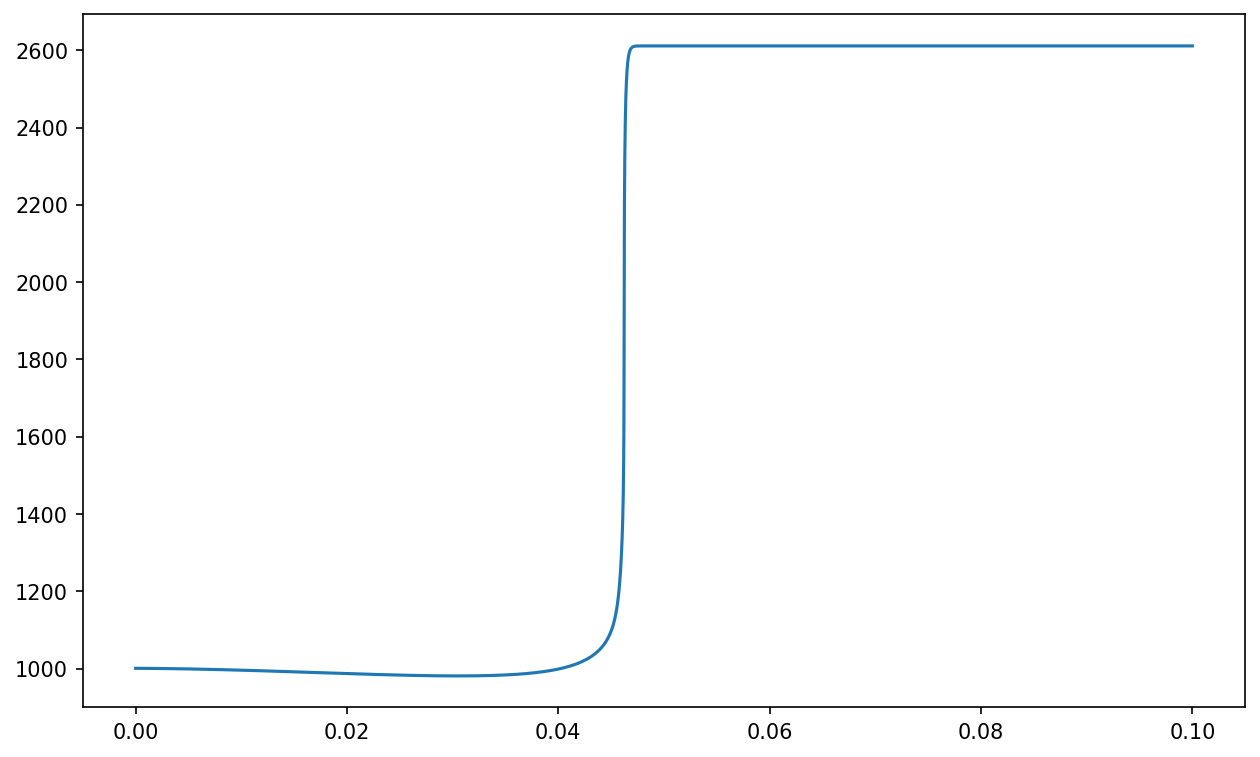

In [12]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.plot(ref_time, ref_temp)
plt.show()

In [14]:
solver_names = []
for i in range(len(solver_configs)):
    solver_names.append(solver_configs[i]['name'])
    
print(solver_names)



['CVODE_BDF', 'QSS_itermax1', 'QSS_itermax2']


In [16]:
all_action_comparison = {}

cpu_times = []
rewards = []
cpu_rewards = []
accuracy_rewards = []
timestep_errors = []
cumulative_errors = []
action = 1
obs, info = env.reset(temperature=temperature, phi=phi, pressure=pressure, total_time=total_time, dt=dt, etol=etol)
# switch_point = 35000
pbar = tqdm(total=env.n_episodes, desc=f'Running solver {solver_names[action]}')
count = 0
switched = False

while True:
    obs, reward, terminated, truncated, info = env.step(action)
    cpu_times.append(info['cpu_time'])
    rewards.append(reward)
    timestep_errors.append(info['timestep_error'])
    count += 1
    pbar.set_postfix(
        T=f'{env.current_state[0]:.1f}K | {env.ref_states[0, 0]:.1f}K/{env.ref_states[0, 0]:.1f}K', 
        P=f'{env.current_pressure/ct.one_atm:.1f}bar',
        phi=f'{env.current_phi:.2f}',
        A=action, 
        R=f'{reward:.1f}', 
        C=f'{info["cpu_time"]:.3f}'
    )
    pbar.update(1)

    if terminated or truncated:
        pbar.close()
        break
    
    if count == 30:
        action = 0
    if count == 50:
        action = 1

if switched:
    action = 0

all_action_comparison[action] = {
    'cpu_times': cpu_times,
    'rewards': rewards,
    'cpu_rewards': cpu_rewards,
    'accuracy_rewards': accuracy_rewards,
    'timestep_errors': timestep_errors,
    'cumulative_errors': cumulative_errors,
    'trajectory': env.states_trajectory,
    'times_trajectory': env.times_trajectory
}

Running solver QSS_itermax1: 100%|██████████| 100/100 [00:57<00:00,  1.75it/s, A=1, C=0.092, P=1.0bar, R=4.4, T=2611.4K | 1000.6K/1000.6K, phi=1.10]


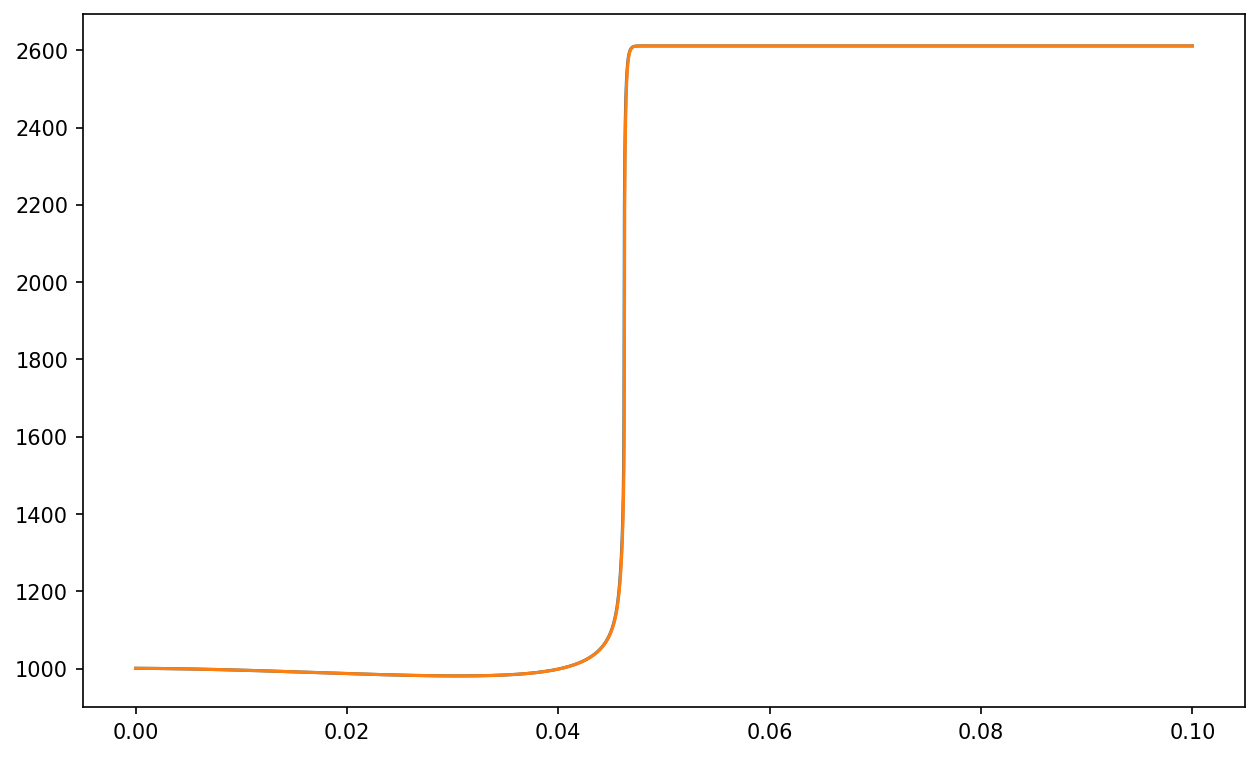

In [19]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.plot(ref_time, ref_temp)
ax.plot(all_action_comparison[action]['times_trajectory'], np.array(all_action_comparison[action]['trajectory'])[:, 0])
plt.show()

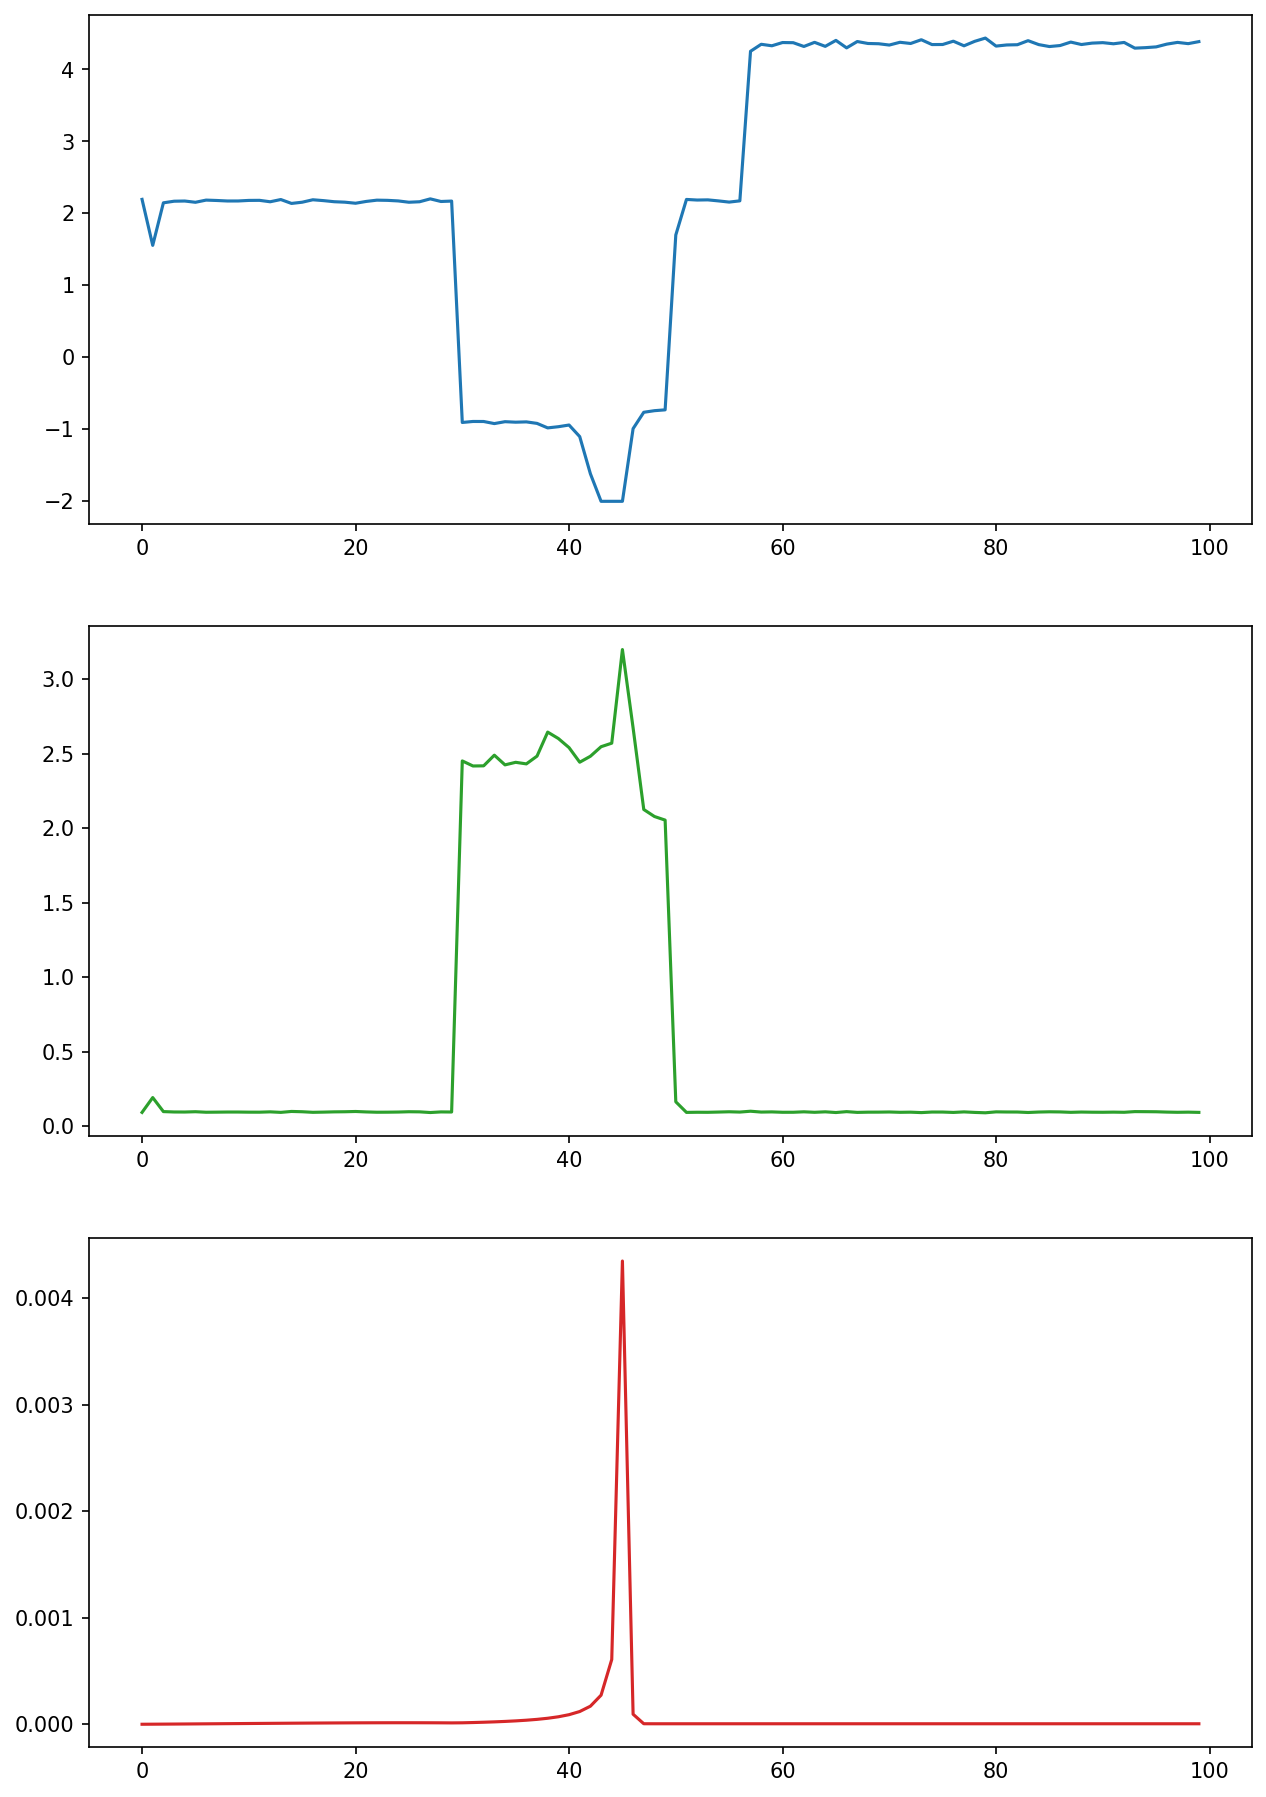

In [21]:
# plot the reward, cpu time, and timestep error
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), dpi=150)
ax1.plot(all_action_comparison[action]['rewards'], color='tab:blue')
ax2.plot(all_action_comparison[action]['cpu_times'], color='tab:green')
ax3.plot(all_action_comparison[action]['timestep_errors'], color='tab:red')
plt.show()


In [37]:
all_action_comparison = {}

In [38]:
from tqdm import tqdm
for action in range(len(solver_configs)):
    cpu_times = []
    rewards = []
    cpu_rewards = []
    accuracy_rewards = []
    timestep_errors = []
    cumulative_errors = []
    obs, info = env.reset(temperature=temperature, phi=phi, pressure=pressure, total_time=total_time, dt=dt, etol=etol)
    # switch_point = 35000
    pbar = tqdm(total=env.n_episodes, desc=f'Running solver {solver_names[action]}')
    count = 0
    switched = False
    while True:
        obs, reward, terminated, truncated, info = env.step(action)
        cpu_times.append(info['cpu_time'])
        rewards.append(reward)
        timestep_errors.append(info['timestep_error'])
        count += 1
        pbar.set_postfix(
            T=f'{env.current_state[0]:.1f}K | {env.ref_states[0, 0]:.1f}K/{env.ref_states[0, 0]:.1f}K', 
            P=f'{env.current_pressure/ct.one_atm:.1f}bar',
            phi=f'{env.current_phi:.2f}',
            A=action, 
            R=f'{reward:.1f}', 
            C=f'{info["cpu_time"]:.3f}'
        )
        pbar.update(1)

        if terminated or truncated:
            pbar.close()
            break
        
        if count == 600 and action == 0:
            print('Switching to QSS')
            switched = True
            action = 1
    
    if switched:
        action = 0
    
    all_action_comparison[action] = {
        'cpu_times': cpu_times,
        'rewards': rewards,
        'cpu_rewards': cpu_rewards,
        'accuracy_rewards': accuracy_rewards,
        'timestep_errors': timestep_errors,
        'cumulative_errors': cumulative_errors,
        'trajectory': env.states_trajectory,
        'times_trajectory': env.times_trajectory
    }


Running solver QSS_itermax2: 100%|██████████| 100/100 [00:08<00:00, 12.49it/s, A=2, C=0.074, P=1.0bar, R=-2.0, T=2235.1K | 991.6K/991.6K, phi=1.93]


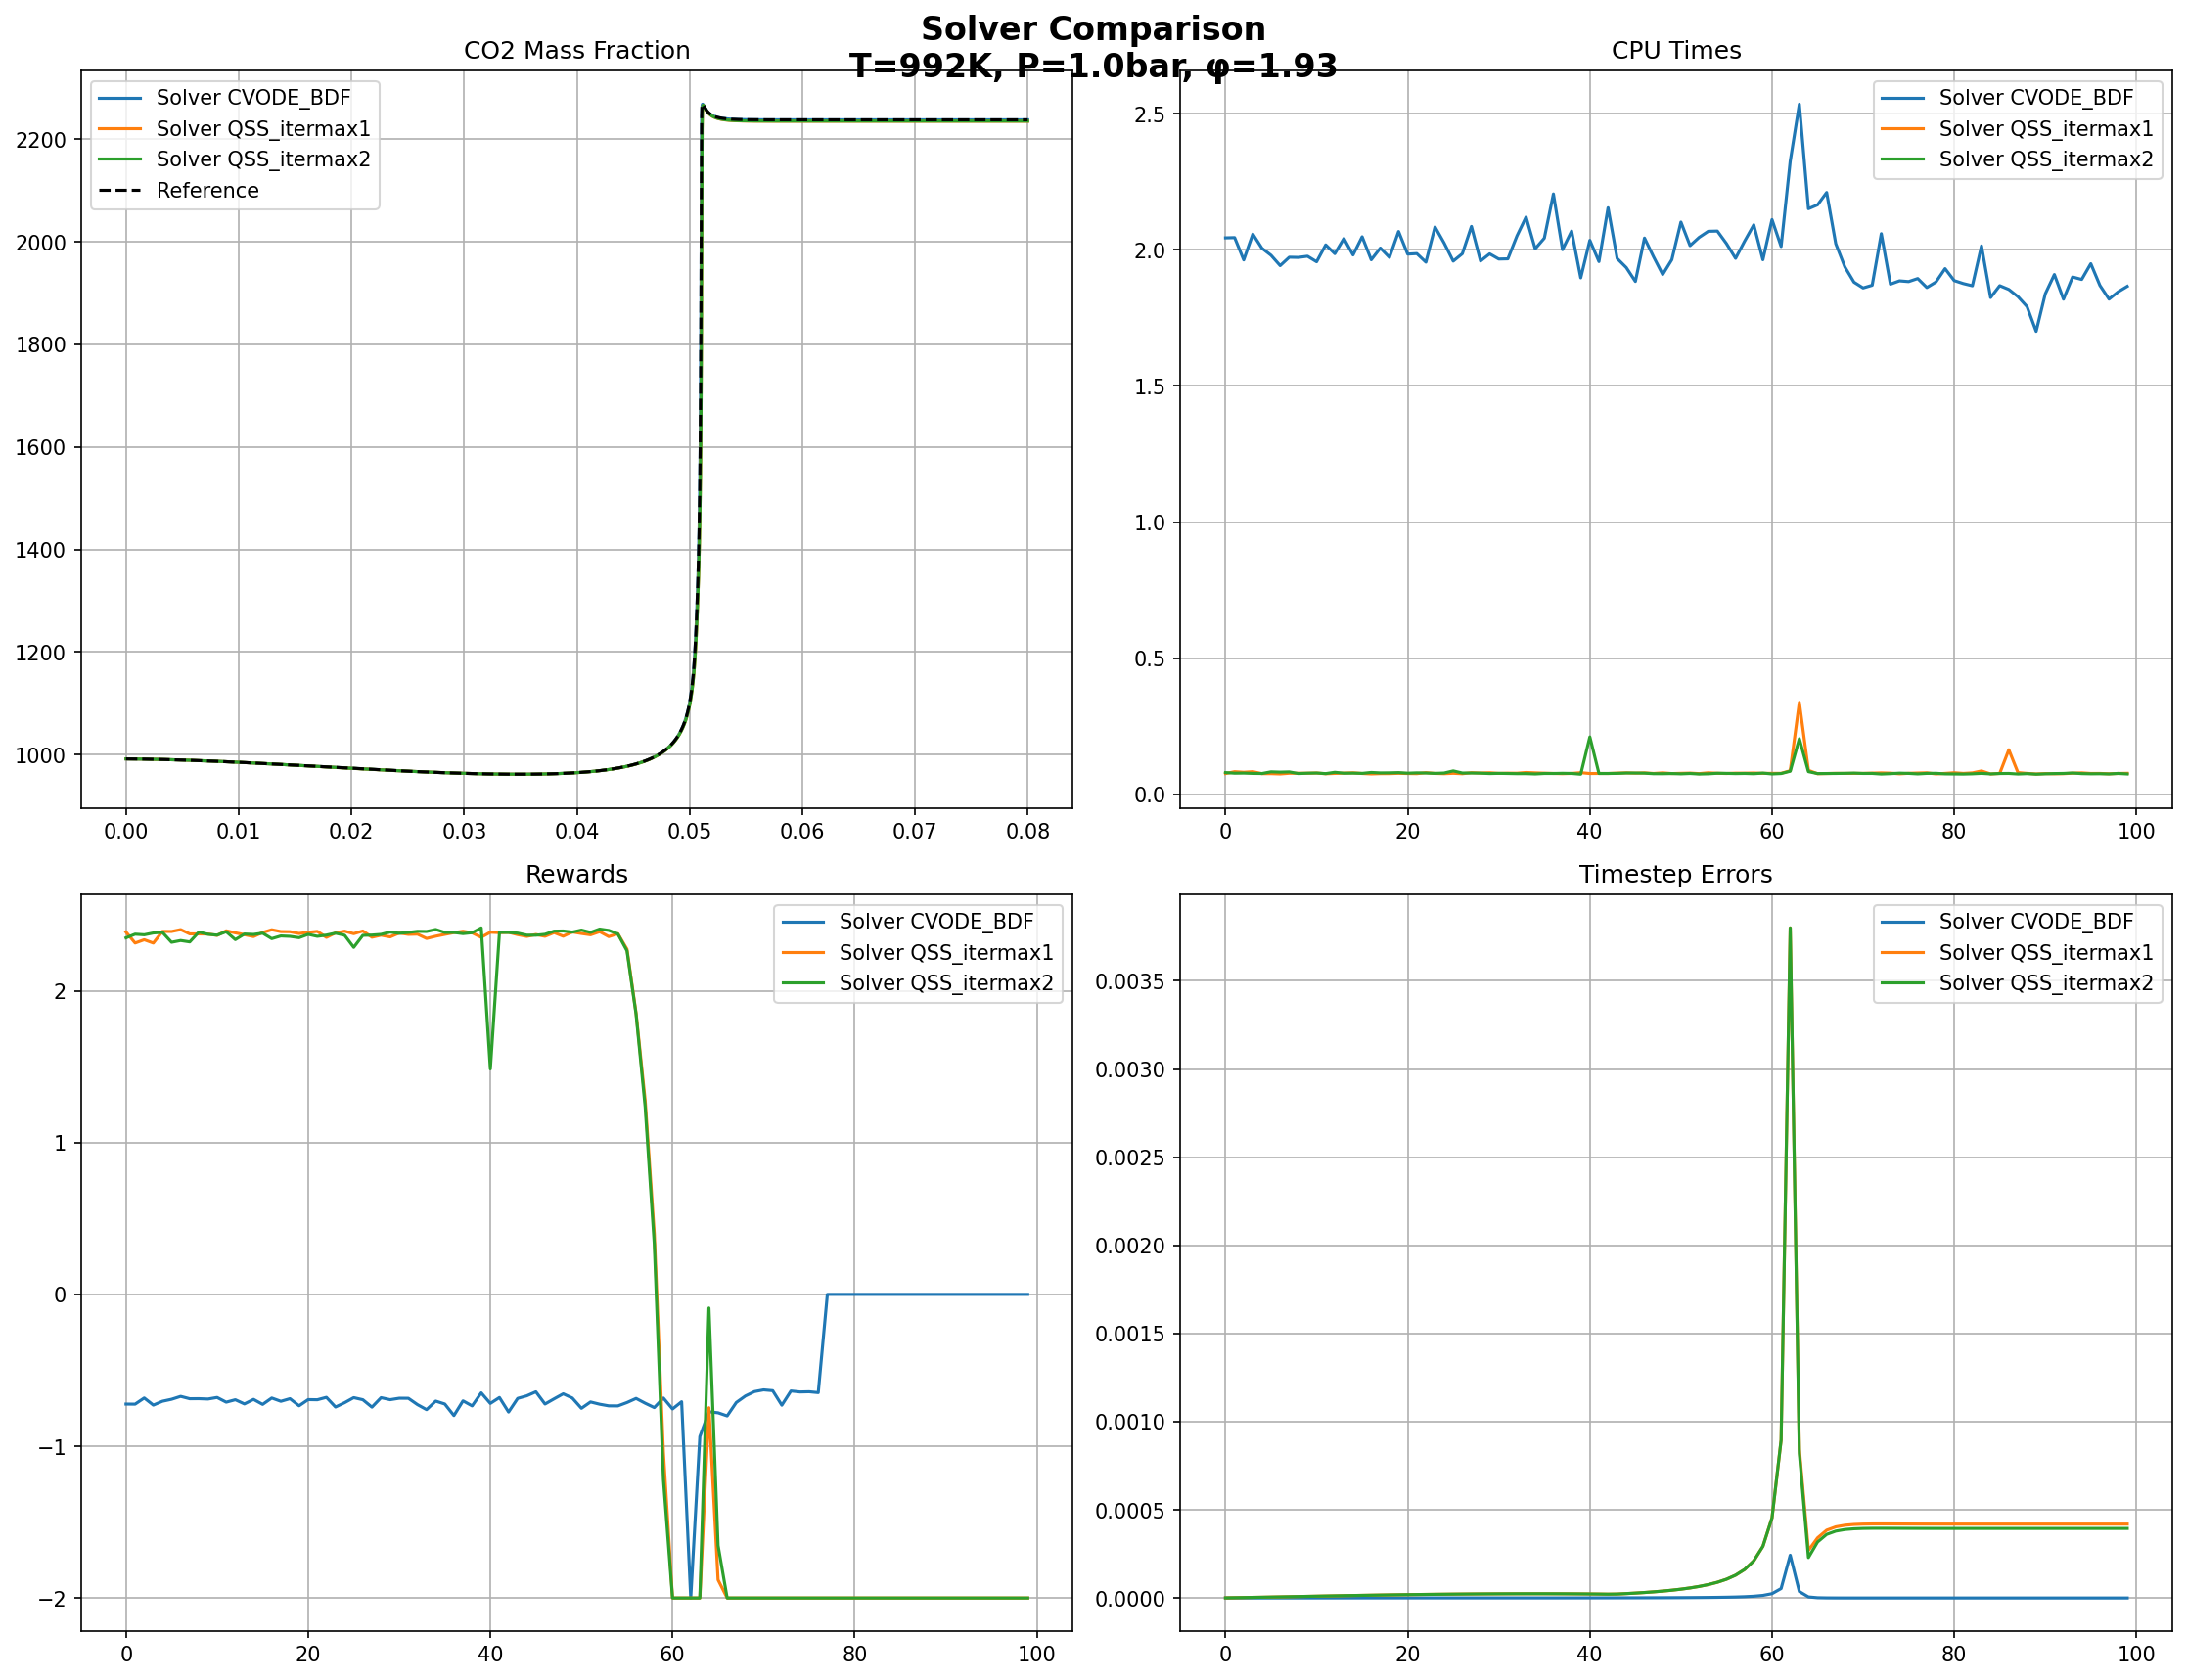

In [40]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12), dpi=150)

species_name = 'CO2'
H20_index = env.gas.species_index(species_name)

for action in range(len(solver_configs)):
    cpu_times = all_action_comparison[action]['cpu_times']
    rewards = all_action_comparison[action]['rewards']
    timestep_errors = all_action_comparison[action]['timestep_errors']
    Y = np.array(all_action_comparison[action]['trajectory'])[:, 0]
    times = all_action_comparison[action]['times_trajectory']
    
    ax1.plot(times, Y, label=f'Solver {solver_names[action]}')
    ax2.plot(np.arange(len(cpu_times)), cpu_times, label=f'Solver {solver_names[action]}')
    ax3.plot(np.arange(len(rewards)), rewards, label=f'Solver {solver_names[action]}')
    ax4.plot(np.arange(len(timestep_errors)), timestep_errors, label=f'Solver {solver_names[action]}')

ax1.plot(ref_time, env.ref_states[:, 0], label='Reference', linestyle='--', color='black')

ax1.set_title(f'{species_name} Mass Fraction')
ax2.set_title('CPU Times')
ax3.set_title('Rewards')
ax4.set_title('Timestep Errors')

for ax in [ax1, ax2, ax3, ax4]:
    ax.legend()
    ax.grid(True)

plt.suptitle(f'Solver Comparison\n'
             f'T={env.ref_states[0, 0]:.0f}K, '
             f'P={pressure/ct.one_atm:.1f}bar, '
             f'φ={phi:.2f}', 
             fontsize=16, fontweight='bold', y=0.95)

plt.tight_layout()
plt.show()
# 

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), dpi=150)

CO2_index = env.gas.species_index('OH')
H2O_index = env.gas.species_index('H2O')


ax1.plot(np.array(env.cpu_times), color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot Gibbs free energy on right y-axis
ax2.set_ylabel('Temperature (K)', color='tab:green')
ax2.plot(np.arange(len(np.array(env.episode_rewards))), np.log10(np.array(env.episode_rewards)), color='tab:green')
# ax2.plot(env.ref_states[:, H2O_index+1], color='tab:red', linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:green')



plt.show()

In [ ]:
np.log10(env.gas.equivalence_ratio(env.fuel, env.oxidizer))

In [ ]:
obs

In [ ]:
env.ref_gas.equivalence_ratio(env.fuel, env.oxidizer)

In [ ]:



from tqdm import tqdm
for action in range(len(solver_configs)):
    cpu_times = []
    rewards = []
    cpu_rewards = []
    accuracy_rewards = []
    timestep_errors = []
    cumulative_errors = []
    obs, info = env.reset(temperature=temperature, phi=phi, pressure=pressure, total_time=total_time, dt=dt, etol=etol)
    # switch_point = 35000
    pbar = tqdm(total=env.n_episodes, desc=f'Running solver {solver_names[action]}')
    count = 0
    while True:
        obs, reward, terminated, truncated, info = env.step(action)
        cpu_times.append(info['cpu_time'])
        rewards.append(reward)
        timestep_errors.append(info['timestep_error'])
        count += 1
        pbar.set_description(f'Running solver {solver_names[action]} - T={env.current_state[0]:.1f}K')
        pbar.update(1)

        if terminated or truncated:
            pbar.close()
            break
    all_action_comparison[action] = {
        'cpu_times': cpu_times,
        'rewards': rewards,
        'cpu_rewards': cpu_rewards,
        'accuracy_rewards': accuracy_rewards,
        'timestep_errors': timestep_errors,
        'cumulative_errors': cumulative_errors,
        'trajectory': env.states_trajectory,
        'times_trajectory': env.times_trajectory
    }


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), dpi=150)

for action in range(len(solver_configs)):
    cpu_times = all_action_comparison[action]['cpu_times']
    rewards = all_action_comparison[action]['rewards']
    temperature = np.array(all_action_comparison[action]['trajectory'])[:, 0]
    times = all_action_comparison[action]['times_trajectory']
    
    
    ax1.plot(times, temperature, label=f'Solver {solver_names[action]}')
    ax2.plot(np.arange(len(cpu_times)), cpu_times, label=f'Solver {solver_names[action]}')
    
ax1.plot(ref_time, ref_temp, label='Reference', linestyle='--', color='black')

ax1.legend()
ax2.legend()

# add a title of the tmperature pressure and phi
plt.suptitle(f'Temperature vs Time\n'
             f'T={temperature[0]:.0f}K, '
             f'P={pressure/ct.one_atm:.1f}bar, '
             f'φ={phi:.2f}', 
             fontsize=16, fontweight='bold', y=0.95)
plt.show()


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), dpi=150)

species_name = 'CO2'
H20_index = env.gas.species_index(species_name)

for action in range(len(solver_configs)):
    cpu_times = all_action_comparison[action]['cpu_times']
    rewards = all_action_comparison[action]['rewards']
    Y = np.array(all_action_comparison[action]['trajectory'])[:, H20_index+1]
    times = all_action_comparison[action]['times_trajectory']
    
    
    ax1.plot(times, Y, label=f'Solver {solver_names[action]}')
    ax2.plot(np.arange(len(cpu_times)), cpu_times, label=f'Solver {solver_names[action]}')
    
ax1.plot(ref_time, env.ref_states[:, H20_index+1], label='Reference', linestyle='--', color='black')

ax1.legend()
ax2.legend()

# add a title of the tmperature pressure and phi
plt.suptitle(f'{species_name} vs Time\n'
             f'T={env.ref_states[0, 0]:.0f}K, '
             f'P={pressure/ct.one_atm:.1f}bar, '
             f'φ={phi:.2f}', 
             fontsize=16, fontweight='bold', y=0.95)
plt.show()
# 

In [ ]:
action_history = env.action_history
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), dpi=150)
ax1.plot(ref_time, ref_temp, label='Reference')

# Plot temperature trajectory colored by action
colors = ['blue', 'red']  # Different color for each solver
times = env.times_trajectory
temps = np.array(env.states_trajectory)[:, 0]
cpu_times = env.cpu_times

# Plot segments with different colors based on action
for i in range(len(action_history)):
    start_idx = i * 50
    end_idx = (i + 1) * 50 if i < len(action_history) - 1 else len(times)
    
    if start_idx < len(times):  # Check if we haven't exceeded trajectory length
        ax1.plot(times[start_idx:end_idx], 
                temps[start_idx:end_idx],
                color=colors[action_history[i]], 
                label=f'Solver {solver_names[action_history[i]]}' if i == 0 or action_history[i] != action_history[i-1] else "")

# plot the cpu time
scatter = ax2.scatter(np.arange(len(cpu_times)), cpu_times, c=action_history, cmap='coolwarm')
ax2.set_xlabel('Time')
ax2.set_ylabel('CPU Time')
ax2.set_title('CPU Time vs Time')
plt.colorbar(scatter)

ax1.legend()
plt.show()

In [ ]:
def get_pressure_range(bias='low'):
    # Create array from 0 to 61 in steps of 3
    pr = np.arange(0, 61, 10)
    pr[0] = 1  # Ensure minimum pressure is 1
    
    # Create weights based on bias
    if bias == 'low':
        # Higher weights for pressures < 10
        weights = np.where(pr < 10, 0.8, 0.2)
    elif bias == 'high':
        # Higher weights for pressures > 10
        weights = np.where(pr > 10, 0.8, 0.2)
    else:
        # Uniform weights
        weights = np.ones_like(pr)
        
    # Normalize weights
    weights = weights / np.sum(weights)
    
    print("Pressure range:", pr)
    print("Weights:", weights)
    print("Number of pressure points:", len(pr))
    
    return pr, weights

# Example usage with low pressure bias
pr, weights = get_pressure_range(bias='low')

sampled_pressure = np.random.choice(pr, size=1, p=weights)
print(sampled_pressure)



In [ ]:
np.log10(60)